Populating the interactive namespace from numpy and matplotlib
[[0.28215856 0.26501579 0.68608418]
 [0.4854197  0.50869073 0.10813298]
 [0.00418084 0.84696929 0.18086016]]


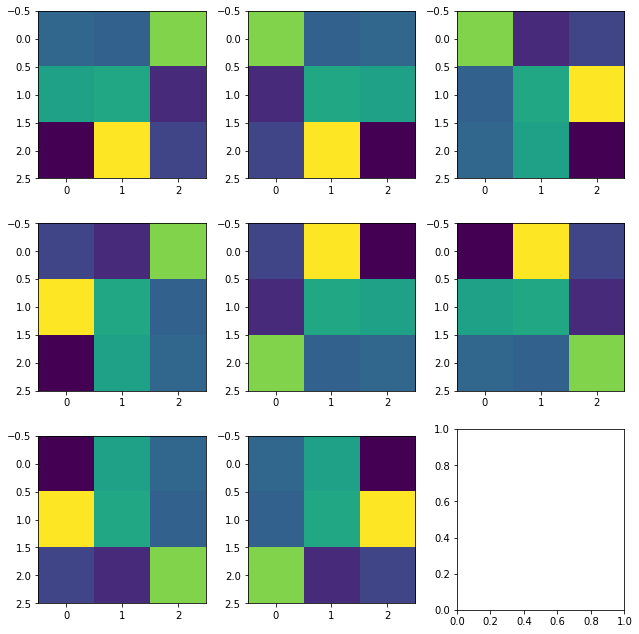

In [1]:
%pylab inline

A = np.random.rand(3,3, )
print (A)

def data_aug2d(A):
    return [A, np.fliplr(A), np.rot90(A), np.fliplr(np.rot90(A)), rot90(rot90(A)), np.fliplr(rot90(rot90(A))), 
     rot90(rot90(rot90(A))), np.fliplr(rot90(rot90(rot90(A))))]

fig, axs = subplots(3,3, figsize=(9,9)); row = 0
As = data_aug2d(A)
for i in range(3):
    for j in range(3):
        axs[i][j].imshow(As[row]); row+=1
        if row == 8: break
fig.tight_layout()

### 以上是数据增强的测试代码，还没成功，忽略。。。从这里开始

##### for some cosmologies data are missing...!!!??? we have to skip them

In [4]:
%pylab inline
import numpy as np
import keras, os, pynbody, struct

lsstr = "ls /media/xiaodongli/0B9ADFB4341AD2BD/om_As/"

def cosmostr(om, As):
    return 'om%.3f' % om + '_As%.3f' % As

def snpfiles(cosmology, snpstr='c'):  #
    return os.popen(lsstr + cosmology + "*snap*" + snpstr + ".*").read().split()

def gridfiles(cosmology, snpstr='c'):
    return os.popen(lsstr + cosmology + "*grid*" + snpstr + ".*").read().split()

def mocklist():
    files = os.popen(lsstr + "om*.lua").read().split('\n')
    # *代替多个字母,即列出所有符合条件的.lua文件:om...
    cosmologies = []  # 宇宙学参数
    mocks = {}  # 模拟测试
    ifile = 0  # 有效文件
    for nowfile in files:
        # str[a:b]不存在时,返回'',不存在则忽略
        nowstr = nowfile[-39:-10]
        if nowstr == '':
            continue
        cosmologies.append(nowstr[0:15])
        ifile += 1
        try:
            mocks[nowstr[0:15]] = {'om': float(nowstr[2:7]), 'As': float(nowstr[10:15]),
                                   'sigma8': float(nowstr[23:29])}
            # 添加随机数种子
            ranseed = float(open(nowfile, 'r').readline().split()[2])  # 默认以所有空字符为分隔符,包括空格,\n,\t
            mocks[nowstr[0:15]]['ranseed'] = int(ranseed)
            # print(ranseed)
        except:
            pass
    return cosmologies, files, mocks

gridfile_dict = {}

cosmologies, filenames, infos = mocklist()
print('In total ', len(cosmologies), 'cosmologies')

print('Build up gridfile_dict... (for speed-up of load_grid()) ')
for cosmology in cosmologies:
    rlt = gridfiles(cosmology)
    if rlt == []:
        print ('\tmissing cosmology!', cosmology)
    else:
        gridfile_dict[cosmology] = rlt[0]

Populating the interactive namespace from numpy and matplotlib
In total  465 cosmologies
Build up gridfile_dict... (for speed-up of load_grid())
	missing cosmology! om0.180_As2.040
	missing cosmology! om0.180_As2.100
	missing cosmology! om0.180_As2.120
	missing cosmology! om0.180_As2.140
	missing cosmology! om0.180_As2.200
	missing cosmology! om0.180_As2.220
	missing cosmology! om0.180_As2.260


In [34]:
def load_grid(gridfile, snpstr='c', printinfo=False):  # 网格加载
    #gridfile = os.popen(lsstr + cosmology+"_sigma8_*grid*" + snpstr + ".*").read().split()[0]
    #print('load in gridfile : ', gridfile, '...')
    nowf = open(gridfile, 'rb')  # 以二进制形式读取文件
    # struct:对python基本类型值与用python字符串格式表示的C struct类型间转化
    size = struct.unpack('f' * 1, nowf.read(4 * 1))[0]
    grid_nc = struct.unpack('i' * 1, nowf.read(4 * 1))[0]
    data = struct.unpack('f' * grid_nc ** 3, nowf.read(4 * grid_nc ** 3))
    if printinfo:
        print('read in box size     \n\t', size)
        print('read in num_grid      \n\t', grid_nc)
        print('read in coarse grid \n\tsize    : ', len(data), '\n\texpect  : ', grid_nc ** 3)

    nowf.close()
    return np.array(data).reshape((grid_nc, grid_nc, grid_nc))

def subcubes(A):
    rlt = []
    for row1 in [0, 32, 64]:
        for row2 in [0, 32, 64]:
            for row3 in [0, 32, 64]:
                rlt.append(A[row1:row1+32,row2:row2+32,row3:row3+32])
    return rlt

def data_augument(A):
    rlt = []


In [35]:
# lsstr = "ls /media/minstrel/Seagate/cola_multiverse/om_As/"
# 初始化数据集,因函数定义中参数不可转为全局变量
# 此过程受train_test_split的test_size参数的影响,则今后更改或维护程序应注意
test_size = 0.3
batch_size = 31
num_subcube = 64
num_data_augument = 48

x_train = np.zeros((batch_size-int(test_size*batch_size)-1, 2))  # 因test_size=0.3,保证初始化矩阵的形状与后面的相同
x_test = np.zeros((int(test_size*batch_size)+1,32,32,32, 1))
y_test = np.zeros((int(test_size*batch_size)+1, 2))
y_train = np.zeros((batch_size-int(test_size*batch_size)-1, 2))


###  xiaodong: 重新写了 load_grid 程序。。。之前有错误！！！！（好像只会 load 进来一个 om...)
def train_generator():  # 必须无限循环yield数据,全部数据遍历后再重新遍历数据,为下一个epoch yield 数据
    i = 0
    while 1:
        X = []
        y = []
        global x_train, x_test, y_test, y_train, test_size, batch_size
        #print(' load in ', batch_size * i, 'to', batch_size * (i + 1), '... len(cosmologies)=',
        #      len(cosmologies))
        for cosmology in cosmologies[batch_size * i: batch_size * (i + 1)]:
            try:
                gridfile = gridfile_dict[cosmology]
                gridfile_exist = True
            except:
                #print('skip cosmology ', cosmology, '!!!')
                gridfile_exist = False
            if gridfile_exist:
                griddata = load_grid(gridfile, 'c')
                for subcube in subcubes(griddata):
                    X.append(subcube)
                    y.append(np.array([infos[cosmology]['om'], infos[cosmology]['sigma8']]))
        X = np.array(X)
        y = np.array(y)
        x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size)
        x_train = x_train.reshape(-1, 32, 32, 32, 1)
        x_test = x_test.reshape(-1, 32, 32, 32, 1)
        i += 1
        yield x_train, y_train  # tuple 类型
        # 15个批次后重新遍历数据,此循环即死循环
        if i == 465//batch_size:
            i = 0

In [ ]:
from keras import Sequential, layers
from sklearn import model_selection, metrics

model1 = keras.Sequential([
    layers.BatchNormalization( input_shape=(32, 32, 32, 1)),
    layers.Conv3D(32, (3, 3, 3), activation='relu'),
    layers.AveragePooling3D(pool_size=(2, 2, 2)),
    layers.BatchNormalization(),
    layers.Conv3D(64, (3, 3, 3), activation='relu'),
    layers.AveragePooling3D(pool_size=(2, 2, 2)),
    layers.BatchNormalization(),
    layers.Conv3D(128, (3, 3, 3), activation='relu'),
    layers.AveragePooling3D(pool_size=(2, 2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(2, ),
])
model1.compile(optimizer=keras.optimizers.Adadelta(), loss='mean_squared_error',
              metrics=['mean_squared_error'])



# *************************************************************************************************
model1.fit_generator(train_generator(),
                    steps_per_epoch=465//batch_size,  # 数据规格可能大小不对应
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test,y_test))
model1.predict(x_test)


Epoch 1/10
 4/15 [=======>......................] - ETA: 2:58 - loss: 7.2250 - mean_squared_error: 7.2250

In [40]:
model1.predict(x_train)

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [39]:
model1.predict(x_train)

array([[0.15126279, 0.84873724],
       [0.16607125, 0.83392876],
       [0.22274914, 0.7772508 ],
       ...,
       [0.2149499 , 0.7850501 ],
       [0.22072959, 0.77927047],
       [0.2102312 , 0.78976876]], dtype=float32)

In [16]:
y_predict = model.predict(x_test)

In [19]:
om_predict = y_predict[:,0]
om_test = y_test[:,0]

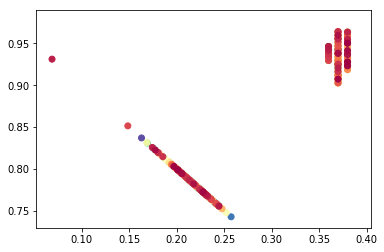

In [31]:
fig, ax = subplots()
cs = range(len(y_test)); cs = cs / mean(cs)
ax.scatter(y_test[:,0], y_test[:,1], c=cs, cmap=plt.cm.Spectral_r)
ax.scatter(y_predict[:,0], y_predict[:,1], c=cs, cmap=plt.cm.Spectral_r)

In [ ]:
from keras import Sequential, layers
from sklearn import model_selection, metrics

model2 = keras.Sequential([
    layers.BatchNormalization( input_shape=(32, 32, 32, 1)),
    layers.Conv3D(2, (3, 3, 3), activation='relu', ),
    layers.BatchNormalization(),
    layers.Conv3D(12, (3, 3, 3), activation='relu', ),
    layers.AveragePooling3D(pool_size=(2, 2, 2),),
    layers.BatchNormalization(),
    layers.Conv3D(64, (9, 9, 9), activation='relu', ),
    layers.BatchNormalization(),
    layers.Conv3D(64, (3, 3, 3), activation='relu', ),
    layers.BatchNormalization(),
    layers.Conv3D(128, (2, 2, 2), activation='relu', ),
    layers.BatchNormalization(),
    layers.Conv3D(128, (2, 2, 2), activation='relu', ),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, ),
])
model2.compile(optimizer=keras.optimizers.Adadelta(), loss='mean_squared_error',
              metrics=['mean_squared_error'])



# *************************************************************************************************
model2.fit_generator(train_generator(),
                    steps_per_epoch=465//batch_size,  # 数据规格可能大小不对应
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test,y_test))
model2.predict(x_test)
